In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_row',100)
pd.set_option('display.max_columns',400)
pd.set_option('display.float_format','{:20,.2f}'.format)
pd.set_option('display.max_colwidth',600)
import json
import os
import gc
import time
import sys
import io
import re
import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn import ensemble
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from pympler import tracker
os.listdir("./data/")

['.DS_Store',
 'indiegogo',
 'data.csv',
 'rules_bak.csv',
 'rules.csv',
 'shopify.csv']

In [68]:
def drawbar(col):
    data = df[col].value_counts().reset_index().rename(columns = {col:'count'})
    sns.barplot(x = 'count',y = 'index',data = data[:25])

In [69]:
def draw_horizontal_bar_compare_roas(col,df):
    d = df[['ROAS',col]].groupby(col).agg({'ROAS': 'mean'}).reset_index().sort_values(by = 'ROAS',ascending = False)[:20]
    sns.barplot(x = 'ROAS',y = col,data = d,orient = 'h')

In [70]:
# new1  
# rules
rules = pd.read_csv('./data/rules.csv',sep = '\t',dtype = {'Ad Set ID':'str','Custom Audiences':'str'},encoding = 'utf-8')
# data
data = pd.read_csv('./data/data.csv',sep = ',',dtype = {'Ad Set ID':'str'},encoding = 'utf-8')
rules['Ad Set ID'] = rules['Ad Set ID'].apply(lambda x: x.split(':')[1])
# summary
data = rules.merge(data,how = 'left',on = 'Ad Set ID')


In [73]:
shopify = pd.read_csv('./data/shopify.csv',sep = ',',encoding = 'utf-8')

# step 1 filter rows and cols
shopify_cosl = ['Created at','Lineitem name','Lineitem quantity','Lineitem price','Discount Amount']
shopify = shopify[shopify_cosl]
shopify = shopify[~shopify['Lineitem name'].str.contains("shipping fee",case = False)]

# step 2 preprocess data
shopify['Discount Amount'].fillna(0,inplace = True)
shopify['Created at'] = pd.to_datetime(shopify['Created at'])
shopify['Date'] = shopify['Created at'].dt.date
shopify['Hour'] = shopify['Created at'].dt.hour

# step 3 feature engineering 
shopify['Total'] = shopify['Lineitem price'] * shopify['Lineitem quantity'] - shopify['Discount Amount']




shopfiy_data_bydate = shopify[['Date','Total']].groupby('Date').agg({'Total':'sum'}).reset_index()



In [53]:
def apply_interest(x):
    if pd.notna(x):
        keys = x.keys()
        for key_num,key in enumerate(keys):
            if key_num != 0:
                result = "|" + key + ":" + x[key][0]['name']
            else:
                result = key + ":" + x[key][0]['name']
            for i in range(1,len(x[key])):
                result = result + '_' + x[key][i]['name']
    else:
        return ''
    return result    

In [54]:
# preprocess and feature engineering
# step 1 change column name
data.rename(columns = {'Ad Set Bid Strategy':'Bid Strategy','Ad Set Daily Budget':'Daily Budget','Flexible Inclusions':'Interest','CPM (Cost per 1,000 Impressions)':'CPM','CTR (Link Click-Through Rate)':'CTR','CPC (Cost per Link Click)':'CPC','Amount Spent (USD)':'Spent','Website Purchases':'Conversions','Cost per Result':'CPR','Website Purchase ROAS (Return on Ad Spend)':'ROAS','Product 1 - Link':'Product Link','Ad Set Name_x':'Ad Set Name'},inplace = True)
    
# step 2 drop unused columns
unused_cols = ['Ad Set Name_y','Reporting Ends','Website Adds to Cart','Website Checkouts Initiated']
data.drop(columns = unused_cols,inplace = True)   
# step 3 null values
cols_nan_zeros = ['CTR','Link Clicks','Conversions','Website Purchases Conversion Value','Landing Page Views','ROAS','Adds to Cart','Spent']
for col in cols_nan_zeros:
    data[col].fillna(0,inplace = True)    
data['Gender'].fillna('All',inplace = True)    
# step 4  interest json expand
data['Interest'] = data['Interest'].apply(lambda x: json.loads(x)[0] if pd.notna(x) else None)
# data['Interest'] = data['Interest'].apply(lambda z: z['interests'][0]['name'] + '_' + z['interests'][1]['name'] if not pd.isnull(z) else '') 
data['Interest'] = data['Interest'].apply(apply_interest) 
# step 5 date format
data['Day'] = pd.to_datetime(data['Day'])
data['DayOfWeek'] = data['Day'].dt.dayofweek
data['DayOfMonth'] = data['Day'].dt.day
data['Month'] = data['Day'].dt.month
data['Date'] = data['Day'].dt.date
# step 6 contries format
data['Countries'] = data['Countries'].astype(str).apply(lambda c: c.replace(',','_').replace(' ',''))
# step 7 age format to str and daily budget
data['Age Max'] = data['Age Max'].astype('str')
data['Age Min'] = data['Age Min'].astype('str')
# step 8  apply lookalike rules to new features
pattern = re.compile(r"^(\w+) \([\w ]+ (\d{1,2}%)\) \- (\w+)$")
# pattern_pixel = re.compile(r"^ERL\_[purchase|checkout|payment](\w+)$")
data['Custom Audiences'] = data['Custom Audiences'].apply(lambda x: x.split(':')[1] if pd.notna(x) else None)
data['Group.Range'] = data['Custom Audiences'].apply(lambda x : pattern.match(x).group(2)   if pd.notna(x) and pattern.match(x) is not None else '')
data['Group.Source'] = data['Custom Audiences'].apply(lambda x : pattern.match(x).group(3) if pd.notna(x) and pattern.match(x) is not None else '')
data['IsLookalike'] = data['Custom Audiences'].apply(lambda x : 1 if pd.notna(x) else 0)
# step 9 CR
data['CR'] = data['Conversions'] / data['Link Clicks']
# step 10 filled na because of no people
cols_nan_nopeople = ['CPC','CPR','CR']
for col in cols_nan_nopeople:
    data[col] = data[col].fillna(-1) 
# step 11 day NAT deleted
data = data[data['Day'].notnull()]


facebook_data_bydate = data[['Date','Spent']].groupby('Date').sum().reset_index()

# step 13  title body 
# data['Title'].fillna("",inplace = True)
# data['Body'].fillna("",inplace = True)
# vectorizer_title = TfidfVectorizer(max_features = 12)
# vectorizer_title.fit(data['Title'])
# df_title_tfidf = pd.DataFrame(vectorizer_title.transform(data['Title']).toarray(),dtype = 'float16',index = data.index)
# df_title_tfidf.columns = [ 'tfidf_title_' + str(id + 1) for id in range(12)]

# vectorizer_body = TfidfVectorizer(max_features = 12)
# vectorizer_body.fit(data['Body'])
# df_body_tfidf = pd.DataFrame(vectorizer_body.transform(data['Body']).toarray(),dtype = 'float16',index = data.index)
# df_body_tfidf.columns = [ 'tfidf_body_' + str(id + 1) for id in range(12)]

# data = pd.concat([data,df_title_tfidf,df_body_tfidf],axis = 1)


In [55]:
data = data[data.Countries.isin(['US','SG','EU'])]
plt.rcParams['figure.figsize'] = (20, 10)


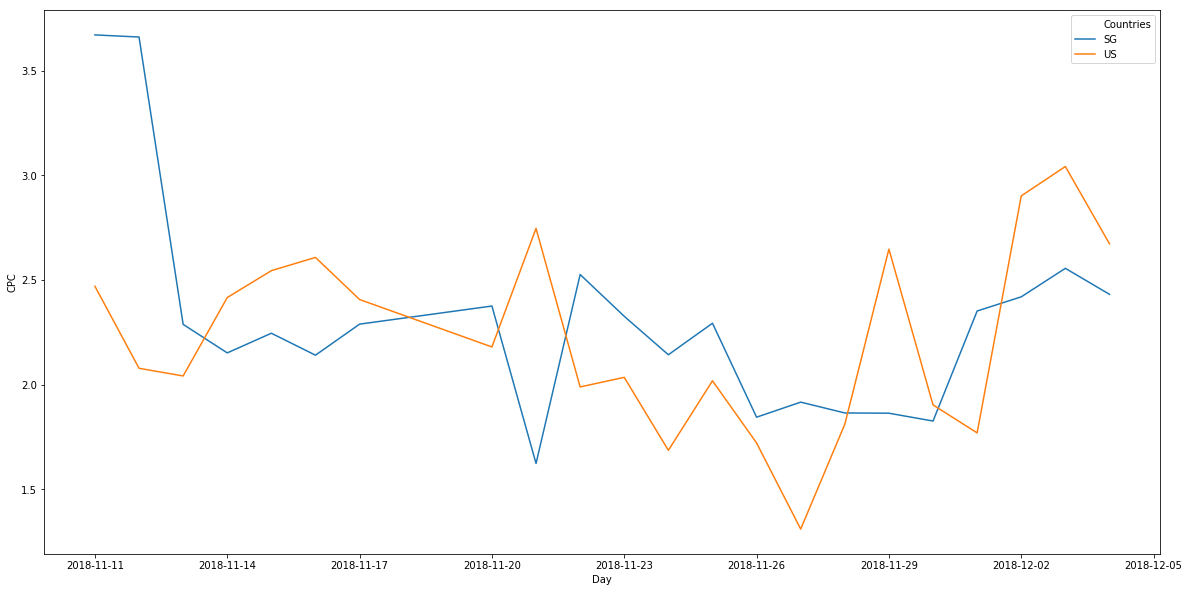

In [56]:
cpc_gropued = data[['CPC','Countries','Day','Link Clicks','Spent']].groupby(by = ['Countries','Day']).agg({'Link Clicks':'sum','Spent':'sum'}).reset_index()
cpc_gropued['CPC'] = cpc_gropued['Link Clicks'] / cpc_gropued['Spent']
sns.lineplot(x = 'Day',y = 'CPC',hue = 'Countries',data =cpc_gropued,markers=True, dashes=False)

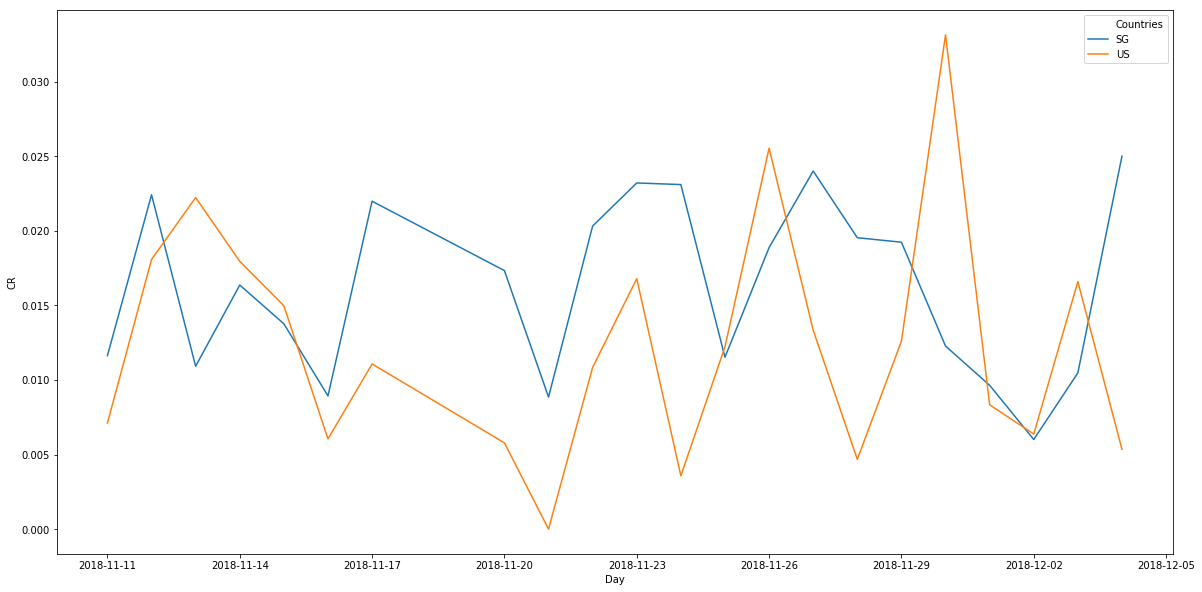

In [57]:
cr_gropued = data[['CR','Countries','Day','Conversions','Link Clicks']].groupby(by = ['Countries','Day']).agg({'Conversions':'sum','Link Clicks':'sum'}).reset_index()
cr_gropued['CR'] = cr_gropued['Conversions'] / cr_gropued['Link Clicks']
sns.lineplot(x = 'Day',y = 'CR',hue = 'Countries',data =cr_gropued )

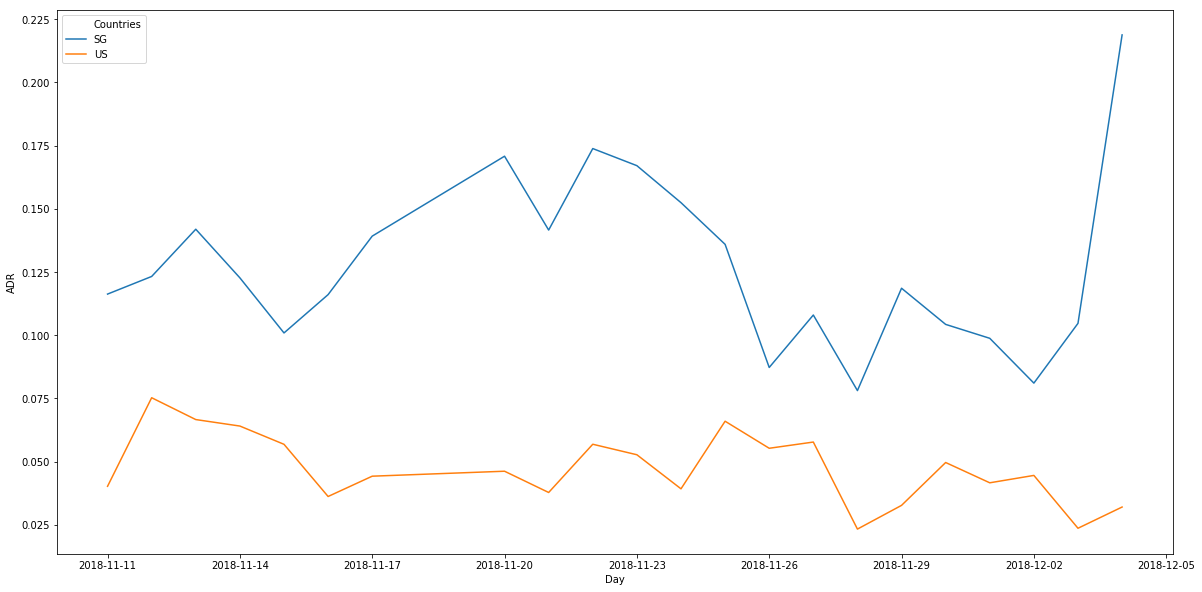

In [58]:
adr_gropued = data[['Countries','Day','Adds to Cart','Link Clicks']].groupby(by = ['Countries','Day']).agg({'Adds to Cart':'sum','Link Clicks':'sum'}).reset_index()
adr_gropued['ADR'] = adr_gropued['Adds to Cart'] / adr_gropued['Link Clicks']
sns.lineplot(x = 'Day',y = 'ADR',hue = 'Countries',data =adr_gropued,markers=True)

In [63]:
roi_data = facebook_data_bydate.merge(shopfiy_data_bydate,on = 'Date',how = 'left')
roi_data['ROI'] = roi_data['Total']  / roi_data['Spent']
roi_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 0 to 22
Data columns (total 4 columns):
Date     23 non-null object
Spent    23 non-null float64
Total    23 non-null float64
ROI      23 non-null float64
dtypes: float64(3), object(1)
memory usage: 920.0+ bytes


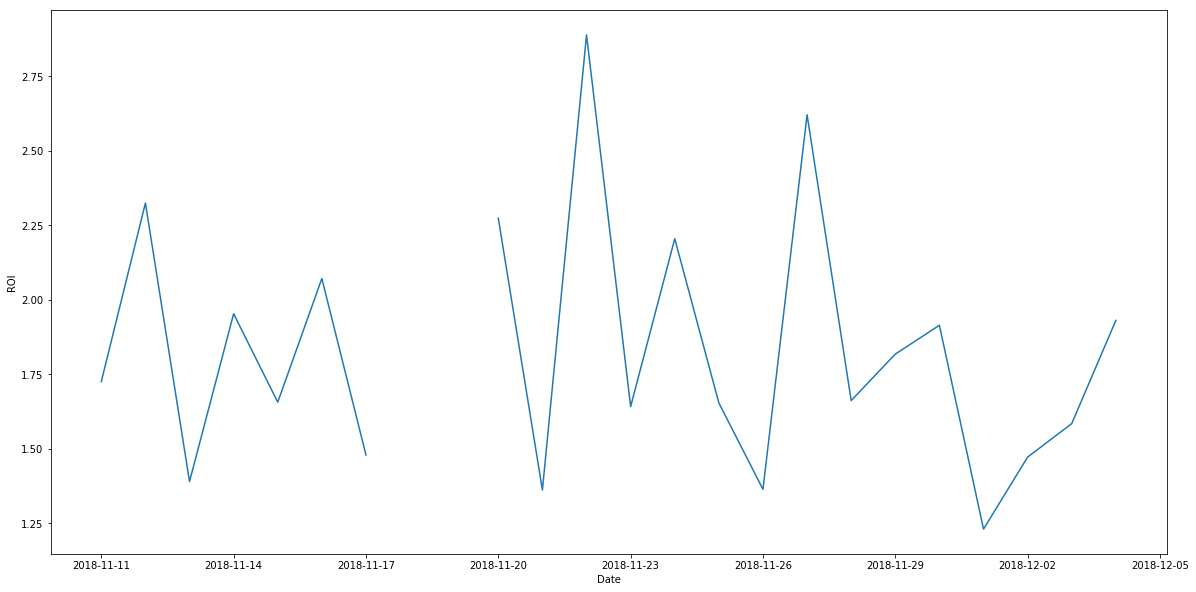

In [64]:
sns.lineplot(x = 'Date',y = 'ROI',data =roi_data,markers=True)

In [66]:
roi_data.head(30)

,Date,Spent,Total,ROI
0,2018-11-11,284.00,490.00,1.73
1,2018-11-12,295.17,686.00,2.32
2,2018-11-13,387.76,539.00,1.39
3,2018-11-14,426.58,833.00,1.95
4,2018-11-15,325.46,539.00,1.66
5,2018-11-16,283.93,588.00,2.07
6,2018-11-17,231.90,343.00,1.48
7,2018-11-18,0.00,49.00,inf
8,2018-11-20,258.65,588.00,2.27
9,2018-11-21,215.93,294.00,1.36


In [74]:
data_byhours = shopify['Hour'].value_counts()

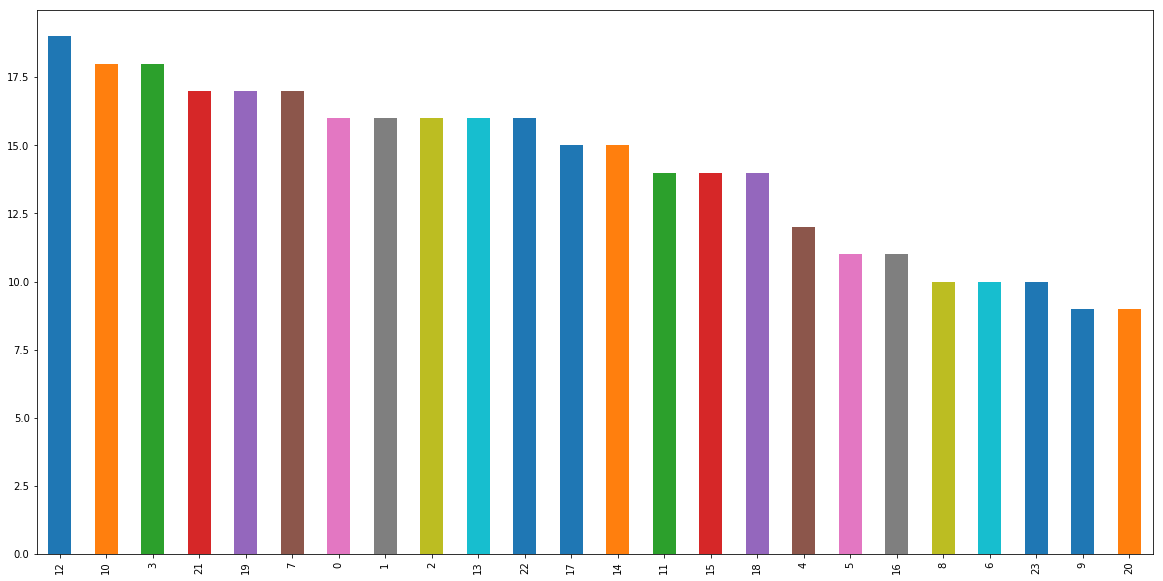

In [78]:
data_byhours.plot.bar()